Before we get started, a couple of reminders to keep in mind when using iPython notebooks:

- Remember that you can see from the left side of a code cell when it was last run if there is a number within the brackets.
- When you start a new notebook session, make sure you run all of the cells up to the point where you last left off. Even if the output is still visible from when you ran the cells in your previous session, the kernel starts in a fresh state so you'll need to reload the data, etc. on a new session.
- The previous point is useful to keep in mind if your answers do not match what is expected in the lesson's quizzes. Try reloading the data and run all of the processing steps one by one in order to make sure that you are working with the same variables and data that are at each quiz stage.


## Load Data from CSVs

In [2]:
import unicodecsv

## Longer version of code (replaced with shorter, equivalent version below)

# enrollments = []
# f = open('enrollments.csv', 'rb')
# reader = unicodecsv.DictReader(f)
# for row in reader:
#     enrollments.append(row)
# f.close()

filelist = ['enrollments.csv','daily_engagement.csv','project_submissions.csv']

def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)
    
enrollments = read_csv(filelist[0])
print len(enrollments)

1640


In [3]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.

daily_engagement = read_csv(filelist[1])
project_submissions = read_csv(filelist[2])

print len(daily_engagement)
print len(project_submissions)

136240
3642


## Fixing Data Types

In [4]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Find unique lists
def uniquevals(listname,keyname):
    uniquelist = set()
    for row in listname:
        uniquelist.add(row[keyname])
    return uniquelist
    
# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])


# Find unique enrollments
unique_enrollments = uniquevals(enrollments,'account_key')
print filelist[0],len(enrollments),len(unique_enrollments)
enrollments[0]

enrollments.csv 1640 1302


{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [5]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [6]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

Note when running the above cells that we are actively changing the contents of our data variables. If you try to run these cells multiple times in the same session, an error will occur.

## Investigating the Data

In [7]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.
unique_engagement = uniquevals(daily_engagement,'acct')
print filelist[1], len(daily_engagement), len(unique_engagement)
unique_submissions = uniquevals(project_submissions,'account_key')
print filelist[2], len(project_submissions),len(unique_submissions)

daily_engagement.csv 136240 1237
project_submissions.csv 3642 743


## Problems in the Data

In [8]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".
for engagement in daily_engagement:
    engagement['account_key'] = engagement['acct']
    del engagement['acct']
    # Add flag for visit
    engagement['has_visited'] = 0
    if engagement['num_courses_visited']>0:
        engagement['has_visited']=1
daily_engagement[0]

{'account_key': u'0',
 'has_visited': 1,
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

## Missing Engagement Records

In [9]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.
problem_students = 0
for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in unique_engagement \
            and enrollment['join_date']!= enrollment['cancel_date']:
        problem_students += 1
print 'Problem students:',problem_students

Problem students: 3


## Checking for More Problem Records

In [10]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.

## Tracking Down the Remaining Problems

In [11]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
print 'Test accounts:',len(udacity_test_accounts)

Test accounts: 6


In [12]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [13]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print 'Non udacity enrollments:',len(non_udacity_enrollments)
print 'Non udacity enagegemnt:',len(non_udacity_engagement)
print 'Non udacity submissions:',len(non_udacity_submissions)

Non udacity enrollments: 1622
Non udacity enagegemnt: 135656
Non udacity submissions: 3634


## Refining the Question

In [14]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students ={}
for enrollment in non_udacity_enrollments:
    if not enrollment['is_canceled'] or enrollment['days_to_cancel']>7:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        paid_students[account_key] = enrollment_date
        # Update with most recent enrollment_date
        if account_key not in paid_students or \
                enrollment_date > paid_students[account_key]:
            paid_students[account_key] = enrollment_date
print 'Paid students:',len(paid_students)

Paid students: 995


## Getting Data from First Week

In [15]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7

In [16]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

def remove_unpaid(data):
    paid_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            paid_data.append(data_point)
    return paid_data

paid_enrollments = remove_unpaid(non_udacity_enrollments)
paid_engagement = remove_unpaid(non_udacity_engagement)
paid_submissions = remove_unpaid(non_udacity_submissions)
print 'Paid enrollments',len(paid_enrollments)
print 'Paid engagement',len(paid_engagement)
print 'Paid submissions',len(paid_submissions)

paid_engagement_in_first_week = []
for engagement in paid_engagement:
    account_key = engagement['account_key']
    join_date = paid_students[account_key]
    engagement_date = engagement['utc_date']
    if within_one_week(join_date,engagement_date):
        paid_engagement_in_first_week.append(engagement)
print 'Paid engagement in first week:', \
        len(paid_engagement_in_first_week)

Paid enrollments 1293
Paid engagement 134549
Paid submissions 3618
Paid engagement in first week: 17210


## Exploring Student Engagement

In [17]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
def totals_by_account(data, parameter):
    engagement_by_account = defaultdict(list)
    for row in data:
        account_key = row['account_key']
        engagement_by_account[account_key].append(row)
    total_values_by_account = {}
    for account_key, engagement in engagement_by_account.items():
        total_values = 0
        for row in engagement:
            total_values += int(row[parameter])
        total_values_by_account[account_key] = total_values
    return total_values_by_account

total_visits_by_account = totals_by_account(paid_engagement_in_first_week,'has_visited')
total_minutes_by_account = \
        totals_by_account(paid_engagement_in_first_week, 'total_minutes_visited')
total_lessons_by_account = \
        totals_by_account(paid_engagement_in_first_week,'lessons_completed')
#paid_engagement_in_first_week[0]


In [18]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
# total_minutes_by_account = {}
# for account_key, engagement_for_student in engagement_by_account.items():
#     total_minutes = 0
#     for engagement_record in engagement_for_student:
#         total_minutes += engagement_record['total_minutes_visited']
#     total_minutes_by_account[account_key] = total_minutes

In [19]:


def print_data(subject, data):
    import numpy as np
    max_data = np.max(data.values())
    print 'Mean ', subject, ':' ,np.mean(data.values())
    print 'Standard deviation ', subject,':', np.std(data.values())
    print 'Minimum ',subject,':', np.min(data.values())
    print 'Maximum ',subject,':', np.max(data.values())
    return max_data

# Summarize the data about minutes spent in the classroom
print_data('minutes used',total_minutes_by_account)




Mean  minutes used : 548.526633166
Standard deviation  minutes used : 959.907085141
Minimum  minutes used : 0
Maximum  minutes used : 10535


10535

## Debugging Data Analysis Code

In [20]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.

## Lessons Completed in First Week

In [21]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.

# Get lessons completed
print_data('lessons completed',total_lessons_by_account)

Mean  lessons completed : 2.68040201005
Standard deviation  lessons completed : 4.79031349245
Minimum  lessons completed : 0
Maximum  lessons completed : 42


42

## Number of Visits in First Week

In [22]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.
# Get days the student visited the classroom
total_visits_by_account = totals_by_account(paid_engagement_in_first_week,'has_visited')
print_data('total visits',total_visits_by_account)

Mean  total visits : 5.75879396985
Standard deviation  total visits : 9.99357132822
Minimum  total visits : 0
Maximum  total visits : 80


80

## Splitting out Passing Students

In [23]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

passing_engagement =[]
non_passing_engagement = []

passing_submission = defaultdict(list)
for submission in project_submissions:
    lesson_key = submission['lesson_key']
    rating = submission['assigned_rating']
    if (rating =='PASSED' or rating == 'DISTINCTION') \
            and lesson_key in subway_project_lesson_keys:
        account_key = submission['account_key']
        passing_submission[account_key].append(submission['account_key'])
print '\nPassing submissions', len(passing_submission)
for engagement in paid_engagement_in_first_week:
    if engagement['account_key'] in passing_submission:
        passing_engagement.append(engagement)
    else:
        non_passing_engagement.append(engagement)

print 'Passing',len(passing_engagement)
print 'Non-passing',len(non_passing_engagement)


Passing submissions 653
Passing 12012
Non-passing 5198


## Comparing the Two Student Groups

In [24]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).

passing_minutes = totals_by_account(passing_engagement,'total_minutes_visited')
print_data('passing minutes',passing_minutes)
passing_lessons = totals_by_account(passing_engagement,'lessons_completed')
print_data('passing lessons',passing_lessons)
passing_visited = totals_by_account(passing_engagement,'has_visited')
print_data('passing visited',passing_visited)
print '======='
non_passing_minutes = totals_by_account(non_passing_engagement,'total_minutes_visited')
print_data('non passing minutes',non_passing_minutes)
non_passing_lessons = totals_by_account(non_passing_engagement,'lessons_completed')
print_data('non passing lessons',non_passing_lessons)
non_passing_visited = totals_by_account(non_passing_engagement,'has_visited')
print_data('non passing visited',non_passing_visited)

Mean  passing minutes : 718.530139104
Standard deviation  passing minutes : 1099.19352139
Minimum  passing minutes : 0
Maximum  passing minutes : 10535
Mean  passing lessons : 3.46831530139
Standard deviation  passing lessons : 5.29078702093
Minimum  passing lessons : 0
Maximum  passing lessons : 42
Mean  passing visited : 7.20401854714
Standard deviation  passing visited : 11.6877900035
Minimum  passing visited : 0
Maximum  passing visited : 80
Mean  non passing minutes : 232.456896552
Standard deviation  non passing minutes : 484.316458579
Minimum  non passing minutes : 0
Maximum  non passing minutes : 4945
Mean  non passing lessons : 1.21551724138
Standard deviation  non passing lessons : 3.20418019304
Minimum  non passing lessons : 0
Maximum  non passing lessons : 29
Mean  non passing visited : 3.07183908046
Standard deviation  non passing visited : 4.52490046343
Minimum  non passing visited : 0
Maximum  non passing visited : 36


36

## Making Histograms

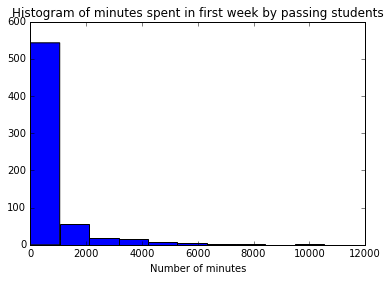

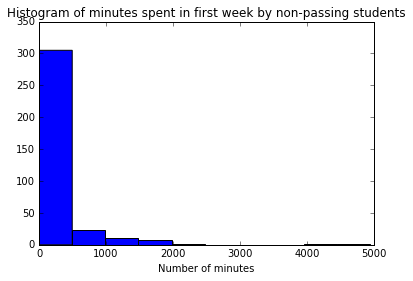

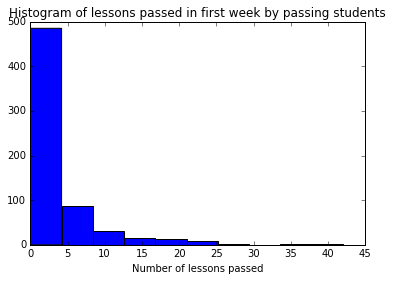

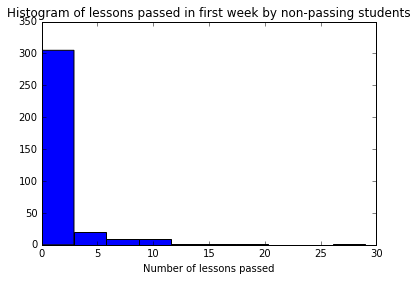

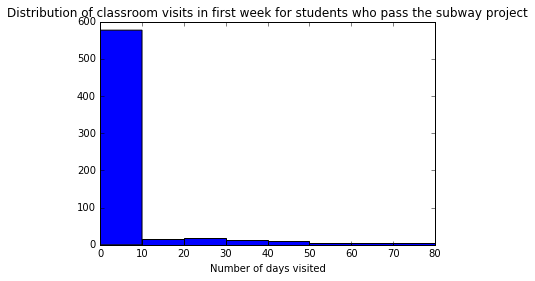

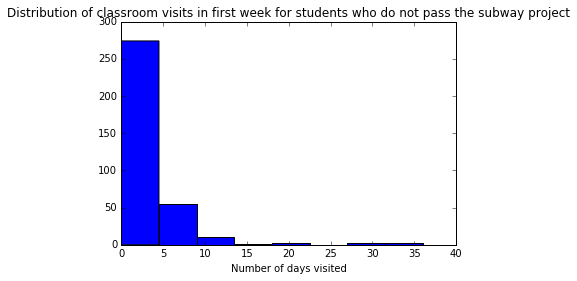

In [34]:


######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.

%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns

def plot_histogram(data,xlabel,title):
    plt.hist(data)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

plot_histogram(passing_minutes.values(),'Number of minutes', \
        'Histogram of minutes spent in first week by passing students')
plot_histogram(non_passing_minutes.values(),'Number of minutes', \
        'Histogram of minutes spent in first week by non-passing students')
plot_histogram(passing_lessons.values(),'Number of lessons passed', \
        'Histogram of lessons passed in first week by passing students')
plot_histogram(non_passing_lessons.values(),'Number of lessons passed', \
        'Histogram of lessons passed in first week by non-passing students')

# Add bins
plt.hist(passing_visited.values(), bins=8)
plt.xlabel('Number of days visited')
plt.title ('Distribution of classroom visits in first week ' + \
        'for students who pass the subway project')
plt.show()

plt.hist(non_passing_visited.values(), bins=8)
plt.xlabel('Number of days visited')
plt.title('Distribution of classroom visits in first week ' + \
        'for students who do not pass the subway project')
plt.show()


## Improving Plots and Sharing Findings

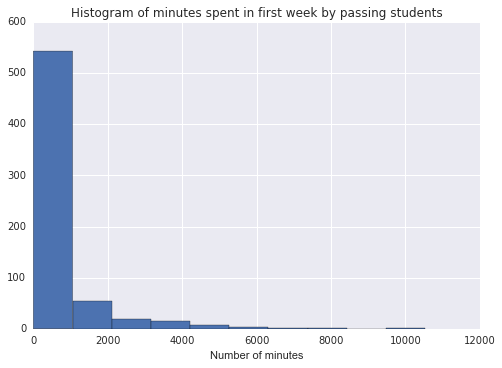

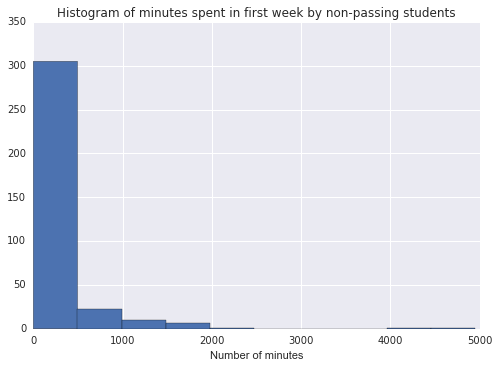

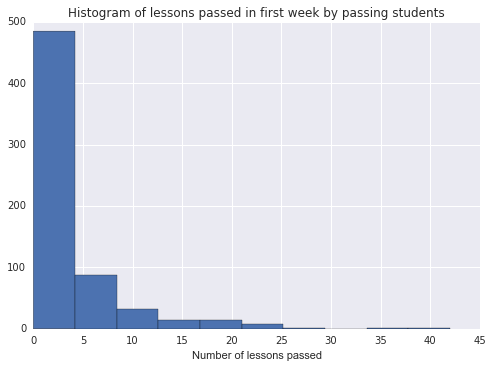

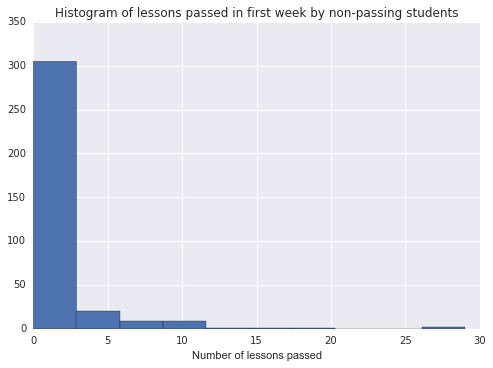

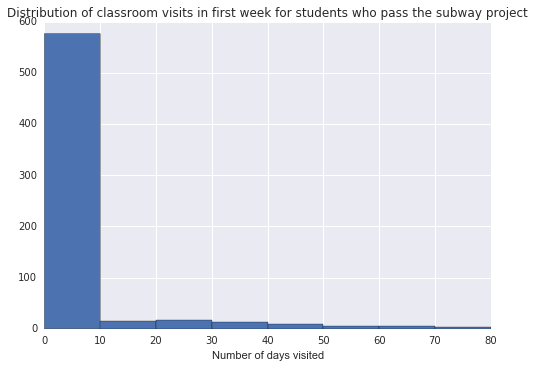

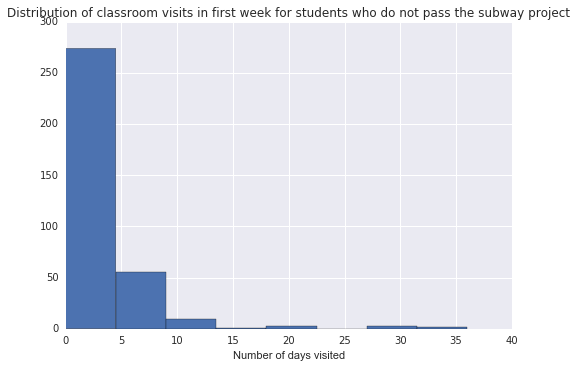

In [36]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.
import seaborn as sns

plot_histogram(passing_minutes.values(),'Number of minutes', \
        'Histogram of minutes spent in first week by passing students')
plot_histogram(non_passing_minutes.values(),'Number of minutes', \
        'Histogram of minutes spent in first week by non-passing students')
plot_histogram(passing_lessons.values(),'Number of lessons passed', \
        'Histogram of lessons passed in first week by passing students')
plot_histogram(non_passing_lessons.values(),'Number of lessons passed', \
        'Histogram of lessons passed in first week by non-passing students')

# Add bins
plt.hist(passing_visited.values(), bins=8)
plt.xlabel('Number of days visited')
plt.title ('Distribution of classroom visits in first week ' + \
        'for students who pass the subway project')
plt.show()

plt.hist(non_passing_visited.values(), bins=8)
plt.xlabel('Number of days visited')
plt.title('Distribution of classroom visits in first week ' + \
        'for students who do not pass the subway project')
plt.show()